In [1]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import psycopg2
import os
import pandas as pd

# open file /run/secrets/postgres_pwd
with open(os.getenv("POSTGRES_PASSWORD_FILE"), 'r') as file:
    password = file.read().strip()

# Connect to your postgres DB
conn = psycopg2.connect(
    host="postgres",      # or IP address
    port=5432,             # default postgres port
    database=os.getenv("POSTGRES_DB"),
    user=os.getenv("POSTGRES_USER"),
    password="mysecretpassword"
)

In [2]:
sql = """
WITH months_count AS (
    SELECT COUNT(DISTINCT DATE_TRUNC('month', event_time)) AS total_months
    FROM customers
    WHERE event_type = 'purchase'
),
last_month AS (
    SELECT MAX(DATE_TRUNC('month', event_time)) AS max_month
    FROM customers
    WHERE event_type = 'purchase'
)
SELECT
    c.user_id,
    COUNT(*)::float / m.total_months AS avg_per_month,
    COUNT(*) FILTER (
        WHERE DATE_TRUNC('month', c.event_time) = l.max_month
    ) AS last_month_purchases
FROM customers c
JOIN months_count m ON true
JOIN last_month l ON true
WHERE c.event_type = 'purchase'
GROUP BY c.user_id, m.total_months, l.max_month
ORDER BY c.user_id;
"""
df = pd.read_sql_query(sql, conn)

/tmp/ipykernel_8514/1848226790.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql, conn)


/tmp/ipykernel_8514/3681373337.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', k)


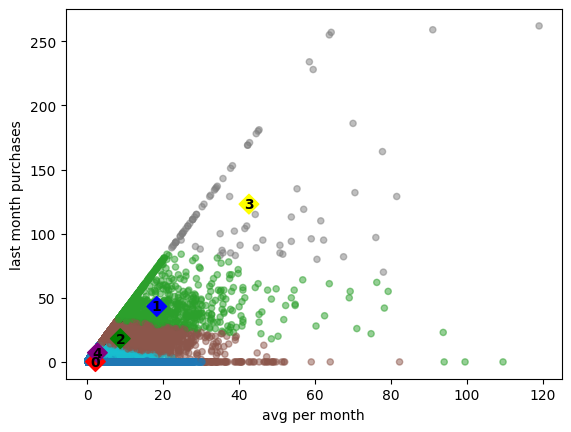

In [3]:
# plot scatter plot with 5 clusters
k = 5
colors = ['red', 'blue', 'green', 'yellow', 'purple']
X= df[['avg_per_month', 'last_month_purchases']].values
m = KMeans(n_clusters=k, random_state=42)
m.fit(X)
for i, (x, y) in enumerate(m.cluster_centers_):
    plt.text(x, y, str(i), fontsize=10, ha='center', va='center', color='black', weight='bold')
cmap = plt.cm.get_cmap('tab10', k)
plt.scatter(X[:, 0], X[:, 1], s=20, alpha=0.5, c=m.labels_, cmap=cmap)
plt.scatter(
    m.cluster_centers_[:, 0], 
    m.cluster_centers_[:, 1], 
    s=100, 
    c=colors,
    marker='D'
    )
plt.xlabel('avg per month')
plt.ylabel('last month purchases')
plt.show()


In [4]:
df['cluster'] = m.labels_

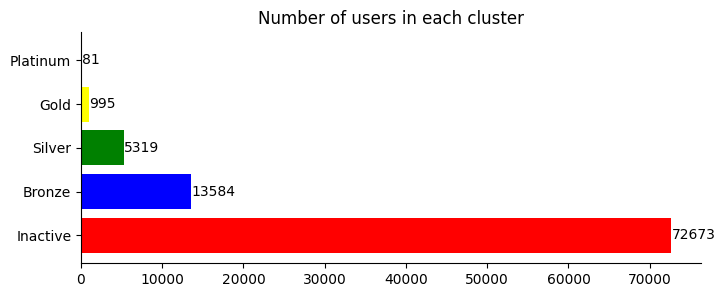

In [5]:
# plot bar chart with cluster and amount of users
yticks = ['Inactive','Bronze','Silver','Gold','Platinum']
plt.figure(figsize=(8, 3))
# barh is horizontal bar chart
bars = plt.barh(yticks, df['cluster'].value_counts(), color=colors)
plt.title('Number of users in each cluster')
plt.yticks(range(len(yticks)), yticks)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 10,
             bar.get_y() + bar.get_height() / 2,
             str(int(width)),
             va='center')
plt.show()